# Quantum pipeline using the Quantum Trainer

In [1]:
from lambeq import BobcatParser, pregroups, AtomicType, SpacyTokeniser, Rewriter
import numpy as np

from lambeq import TketModel,remove_cups, QuantumTrainer, SPSAOptimizer
from pytket.extensions.qiskit import AerBackend

import matplotlib.pyplot as plt

from lambeq import AtomicType,BinaryCrossEntropyLoss, Dataset

from lambeq import NumpyModel

from lambeq import IQPAnsatz,Sim15Ansatz

from utils.FslAnsatz import FslSim15Ansatz, FslStronglyEntanglingAnsatz, FslBaseAnsatz

import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

### Fsl ansatz

In [2]:
preq_embeddings={}
with open("resources\embeddings\common_crawl\glove.42B.300d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        preq_embeddings[word] = vector

### Read in the data and create diagrams

In [3]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences

In [ ]:
train_labels, train_data = read_data('resources/dataset/mc_train_data.txt')
dev_labels, dev_data = read_data('resources/dataset/mc_dev_data.txt')
test_labels, test_data = read_data('resources/dataset/mc_test_data.txt')

In [4]:
new_train_labels, new_train_data = read_data('resources\dataset\\new_mc_clean_all_data.txt')

In [5]:
indices = np.arange(len(new_train_data))
np.random.shuffle(indices)
new_train_data =np.array(new_train_data)[indices]
new_train_labels=np.array(new_train_labels)[indices]

In [20]:
new_train_data.shape[0]

8861

In [6]:
train_labels=new_train_labels[0:2953].tolist()
train_data=new_train_data[0:2953].tolist()
test_labels=new_train_labels[2954:5906].tolist()
test_data=new_train_data[2954:5906].tolist()
dev_labels=new_train_labels[5907:].tolist()
dev_data=new_train_data[5907:].tolist()

In [30]:
train_labels=new_train_labels[0:2953]
train_data=new_train_data[0:2953]
test_labels=new_train_labels[2954:5906]
test_data=new_train_data[2954:5906]
dev_labels=new_train_labels[5907:]
dev_data=new_train_data[5907:]

In [7]:
TESTING = int(os.environ.get('TEST_NOTEBOOKS', '0'))
TESTING=True
if TESTING:
    train_labels, train_data = train_labels[:2], train_data[:2]
    dev_labels, dev_data = dev_labels[:2], dev_data[:2]
    test_labels, test_data = test_labels[:2], test_data[:2]
    EPOCHS = 1

### Create diagrams

In [8]:
parser = BobcatParser(verbose='text')
tokeniser = SpacyTokeniser()
raw_train_tokens = tokeniser.tokenise_sentences(train_data)
raw_train_tokens = [tokens[:-1] for tokens in raw_train_tokens]
raw_dev_tokens = tokeniser.tokenise_sentences(dev_data)
raw_dev_tokens = [tokens[:-1] for tokens in raw_dev_tokens]
raw_test_tokens = tokeniser.tokenise_sentences(test_data)
raw_test_tokens =  [tokens[:-1] for tokens in raw_test_tokens]

raw_train_diagrams = parser.sentences2diagrams(raw_train_tokens,tokenised=True)
raw_dev_diagrams = parser.sentences2diagrams(raw_dev_tokens,tokenised=True)
raw_test_diagrams = parser.sentences2diagrams(raw_test_tokens,tokenised=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


### Remove the cups

In [9]:
train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

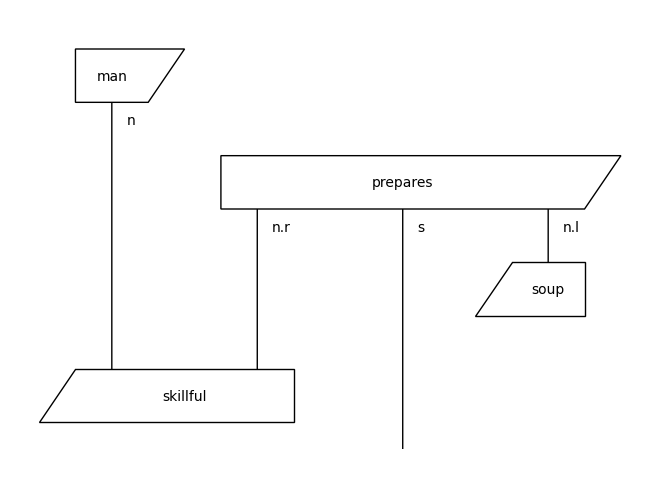

In [33]:
train_diagrams[1].draw()

### Create circuits

#### Variables

In [30]:
# Define atomic types
N = AtomicType.NOUN
S = AtomicType.SENTENCE
map={N:1,S:1}
n_layers=1
alpha="Sim15Ansatz"
beta="FslBase"
gamma="FslSim15"
ansatz_string=beta
print(ansatz_string)
match ansatz_string:
    case "FslBase":
        ansatz = FslBaseAnsatz(preq_embeddings,map, n_layers=n_layers)
    case "FslSim15":
        ansatz = FslSim15Ansatz(preq_embeddings,map, n_layers=n_layers)  
    case "Sim15Ansatz":
        ansatz = Sim15Ansatz(map,n_layers=n_layers, n_single_qubit_params=3)

FslBase


#### Create circits

In [31]:
train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

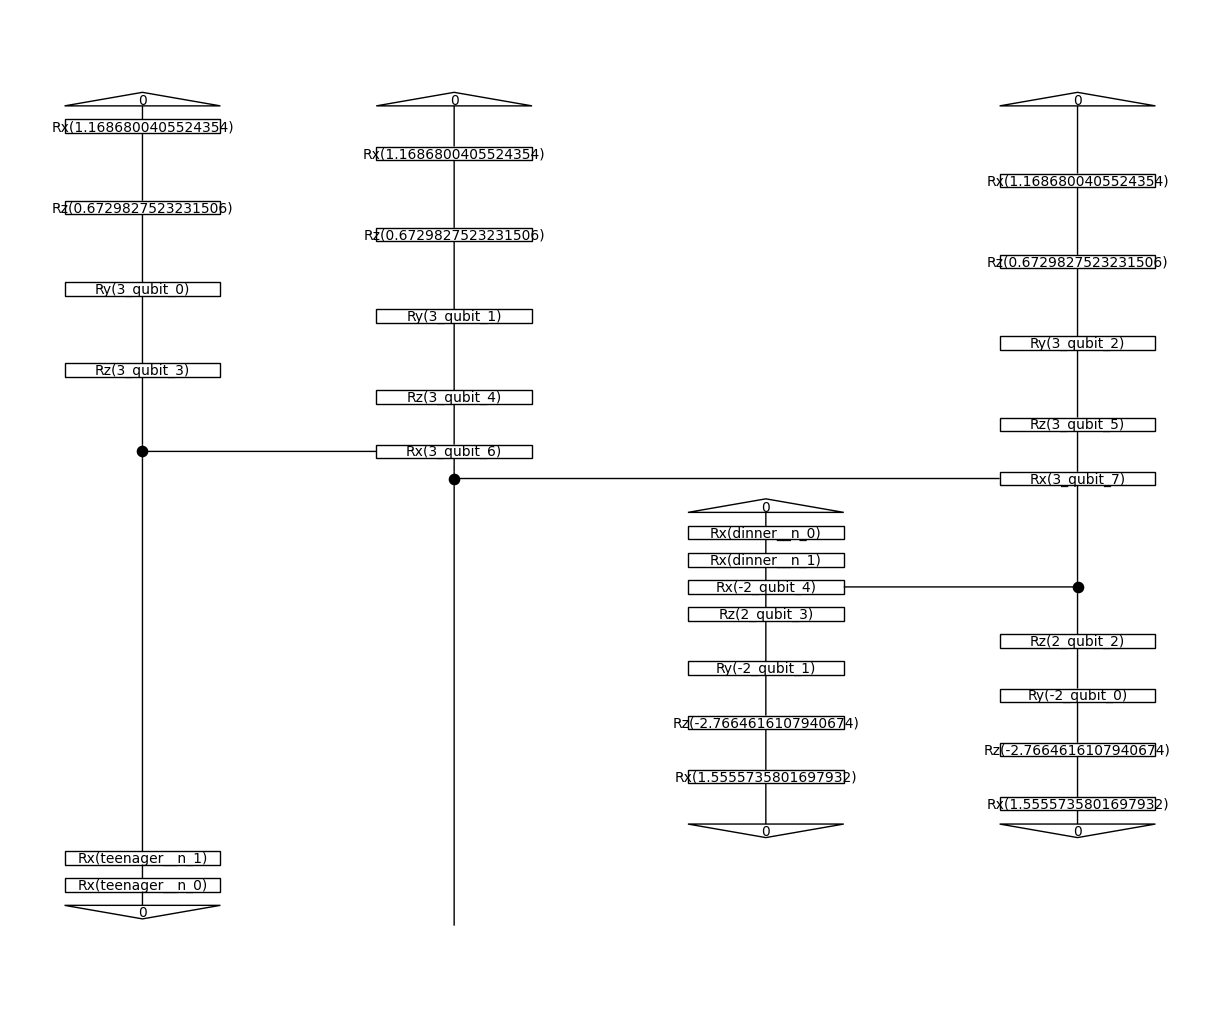

In [42]:
train_circuits[1].draw(figsize=(12, 10))

### Parameterise

In [33]:
all_circuits = train_circuits+dev_circuits+test_circuits

#### TketModel

In [18]:
backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}
model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

#### NumpyModel

In [34]:
model = NumpyModel.from_diagrams(all_circuits, use_jit=True)

### Define evaluation metric

In [14]:
# Using the builtin binary cross-entropy error from lambeq
bce = BinaryCrossEntropyLoss()
loss_function="BindaryCrosEntropyLoss"
acc_function="lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2"
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

### Initialize trainer

In [36]:
checkpoint=False
EPOCHS=2000
BATCH_SIZE = 1500
SEED = 2
a=0.05
c=0.06
A="0.1*Epochs"
logdir='2systematic_runs\JITTRIAL_Epochs_{}--A_{}--N_{}--S_{}--L_{}--Ansatz_{}'.format(EPOCHS,a,map[N],map[S],n_layers,ansatz_string)


In [42]:
if checkpoint:
    model=NumpyModel.from_checkpoint(logdir+'\model.lt')
    print('Checkpoint')

In [37]:
trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': a, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0,
    from_checkpoint=checkpoint,
    log_dir=logdir
)

In [38]:
train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels, shuffle=False)

### Train

In [39]:
trainer.fit(train_dataset, val_dataset, log_interval=10, eval_interval=1)

TypeError: iteration over a 0-d array

### Show results

Test accuracy: 0.5


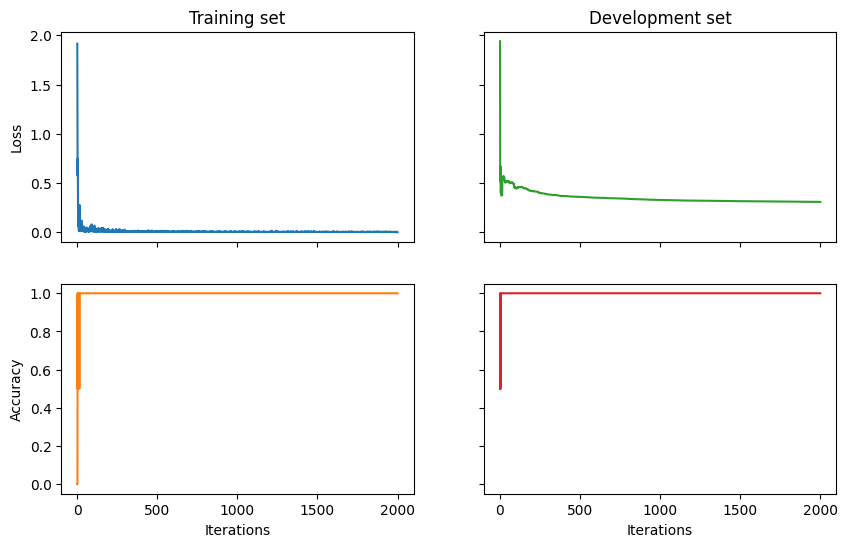

In [21]:
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs + 1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))
plt.savefig(logdir+'\plot.png')

model=NumpyModel.from_checkpoint(logdir+'\\model.lt')
test_acc = acc(model(test_circuits), test_labels)

best_model=NumpyModel.from_checkpoint(logdir+'\\best_model.lt')
best_model_test_acc = acc(best_model(test_circuits), test_labels)
#test_acc = acc(model(test_circuits), test_labels)
print('Test accuracy:', test_acc)


### saving everything

In [22]:
file_path = f"{logdir}/info_file.txt"
with open(file_path, 'w') as file:
    # Write the input string to the file
    input_string=f"""Task: Meaning classification
Classical Embeddings: GloVe 50-d
Parsing: True
Rewritign: Remove Cups
Ansatz: {ansatz_string}
Layers: {n_layers}
Map: [N:{map[N]}, S:{map[S]}]
Model: Numpy
Backend: None
Trainer: Quantum Trainer
Loss function: {loss_function}
Accuracy function: {acc_function}
Optimizer: SPSA optimizer
Epochs: {EPOCHS}
Batch size: {BATCH_SIZE}
Seed: {SEED}
Hyperparams: [a:{a},c:{c},A:{A}]
Test accuracy: {test_acc}
Test accuracy best model: {best_model_test_acc}"""
    file.write(input_string)